In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from yellowbrick.classifier import ClassPredictionError
from sklearn.naive_bayes import MultinomialNB
import warnings
warnings.filterwarnings("ignore")

# from yellowbrick.classifier import ClassPredictionError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [3]:
df = pd.read_csv('p3_dataset.csv')
print(df.shape)
df = df.drop_duplicates()
df

(11858, 2)


,text,class
0,latest headlin cnn busi tl dr u govern expect ...,ctrl
1,china want take victori lap handl coronaviru o...,ctrl
2,coronaviru disinform creat challeng china gove...,ctrl
3,china coronaviru eat wild anim made illeg end ...,ctrl
4,china economi could shrink first time decad co...,ctrl
...,...,...
11853,today world concern authoritarian racism natio...,instruct_gpt
11854,keep space station clean astronaut must practi...,instruct_gpt
11855,citi requir tenant pay first month rent someti...,instruct_gpt
11856,it’ easi brows customis app get news way keep ...,instruct_gpt


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11696 entries, 0 to 11857
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11696 non-null  object
 1   class   11696 non-null  object
dtypes: object(2)
memory usage: 274.1+ KB


### Splitting the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['class'],
                                                    stratify = df['class'],
                                                    test_size = 0.2,
                                                    random_state = 1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9356,) (2340,) (9356,) (2340,)


In [6]:
y_train.value_counts()

gpt3            960
xlnet           853
gpt             853
fair            853
ctrl            853
gpt2            852
xlm             852
grover          852
instruct_gpt    851
human           792
pplm            785
Name: class, dtype: int64

In [7]:
v = TfidfVectorizer()

X_train = v.fit_transform(X_train)
X_test = v.transform(X_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9356, 49558) (2340, 49558) (9356,) (2340,)


In [8]:
X_train

<9356x49558 sparse matrix of type '<class 'numpy.float64'>'
	with 1466749 stored elements in Compressed Sparse Row format>

### Model Training

In [9]:
labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt']
    
def visualizer(clf):
    visualizer = ClassPredictionError(clf, classes= labels)

    # Fit the training data to the visualizer
    visualizer.fit(X_train, y_train)

    # Evaluate the model on the test data
    visualizer.score(X_test, y_test)

    # Draw visualization
    visualizer.show()
    
from yellowbrick.classifier import ConfusionMatrix

def get_confusion_matrix(model):
   
    cm = ConfusionMatrix(
        model, classes=labels,
        percent=True
        #label_encoder={0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}
    )
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    cm.show();

from sklearn.metrics import roc_curve, auc, roc_auc_score
    
def metrics(pred):
    matrix = confusion_matrix(y_test, pred, labels = labels)
    mat = matrix.diagonal()/matrix.sum(axis=1)
    print(classification_report(y_test, pred, labels = labels,
                                digits=4))

    print('confusion matrix: ', mat)

    Accuracy = accuracy_score(y_test,pred)
    F1 = f1_score(y_test, pred, average='macro')
    print("Accuracy:", Accuracy)

    rec = recall_score(y_test, pred, average='macro')
    print('Recall: ', rec)
    prec = precision_score(y_test, pred, average='macro')
    print('Precision: ', prec)

    print('F1:', F1)
    
def get_predictions(tpr, fpr, threshold, ypred):
    #If tpr is hight & fpr is low : (tpr*(1-fpr)) is maximum
    actual_ypred = []

    thres = threshold[np.argmax(tpr * (1 - fpr))]
    for value in ypred:
        if value < thres:
            actual_ypred.append(0)
        else:
            actual_ypred.append(1)
    return actual_ypred
    
# def get_roc_curve(model_name, classifier):
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model):
    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, classes = labels)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer


def get_confusion_matrix(model_name, roc_results):
    actual_ypred_train = get_predictions(roc_results['tpr_train'],
                                         roc_results['fpr_train'],
                                         roc_results['threshold_train'],
                                         roc_results['ypred_train'])

    matrix_train = confusion_matrix(y_train, actual_ypred_train)

    actual_ypred_test = get_predictions(roc_results['tpr_test'],
                                        roc_results['fpr_test'],
                                        roc_results['threshold_test'],
                                        roc_results['ypred_test'])

    matrix_test = confusion_matrix(y_test, actual_ypred_test)

    plt.rcParams["figure.figsize"] = [12, 5]
    plt.rcParams["figure.autolayout"] = True
    f, axes = plt.subplots(1, 2)
    
    axes[0].title.set_text(f'{model_name} Training Confusion Matrix')
    sns.heatmap(matrix_train, annot = True, ax = axes[0], fmt = "d")


    sns.heatmap(matrix_test, annot = True, ax = axes[1], fmt = "d")
    axes[1].title.set_text(f'{model_name} Testing Confusion Matrix')

    return actual_ypred_test, actual_ypred_train

### Random Forest Classifier

In [10]:
randomforest_model = RandomForestClassifier()

parameters = { 'max_depth' : [10, 20, 30],
               'n_estimators' : [90, 150, 180],
               'max_samples' : [0.6, 0.8]
 }

cross_validation = 3
scoring_metric = "f1"
randomforest_model_cv = GridSearchCV(randomforest_model, 
                                     parameters,
                                     cv = cross_validation,
                                     scoring = scoring_metric,
                                     return_train_score=True)

randomforest_model_cv.fit(X_train, y_train)
print('Best Params ', randomforest_model_cv.best_params_)

Best Params  {'max_depth': 10, 'max_samples': 0.6, 'n_estimators': 90}


In [19]:
parameters = {
     'max_depth' : 10,
     'n_estimators' : 90,
     'max_samples' : 0.6
}
randomforest_model = RandomForestClassifier(max_depth = parameters['max_depth'],
                                            max_samples = parameters['max_samples'],
                                            n_estimators = parameters['n_estimators'])

randomforest_model.fit(X_train, y_train)
pred = randomforest_model.predict(X_test)

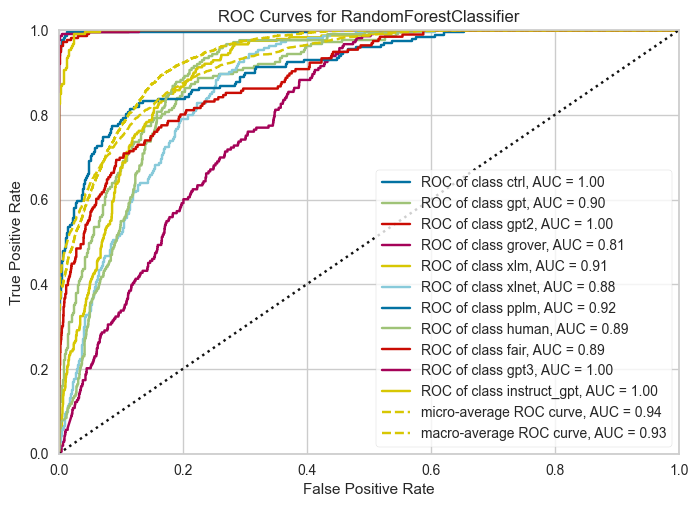

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm',
                'human', 'fair', 'gpt3', 'instruct_gpt'],
       estimator=RandomForestClassifier(max_depth=10, max_samples=0.6,
                                        n_estimators=90))

In [20]:
plot_ROC_curve(randomforest_model)

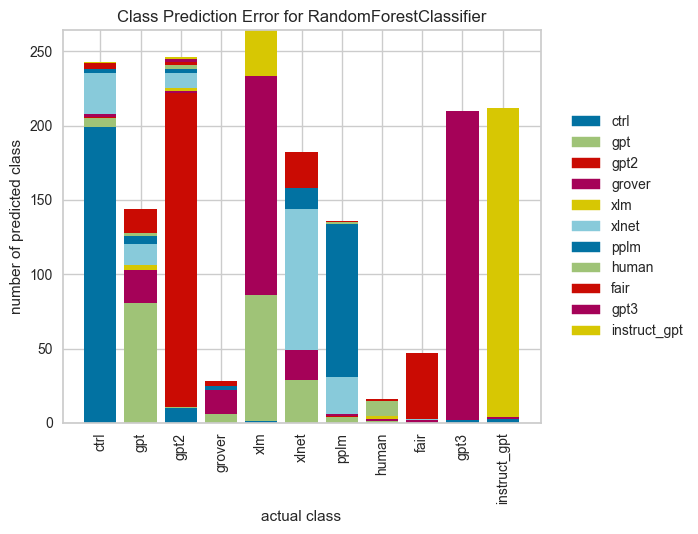

In [21]:
visualizer(randomforest_model)

In [22]:
get_confusion_matrix(randomforest_model)

TypeError: get_confusion_matrix() missing 1 required positional argument: 'roc_results'

In [23]:
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, confusion_matrix
matrix = confusion_matrix(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'])
mat = matrix.diagonal()/matrix.sum(axis=1)
print(classification_report(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover','xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'],
                            digits=4))
print('confusion matrix: ', mat)

Accuracy = accuracy_score(y_test,pred)
F1 = f1_score(y_test, pred, average='macro')
print("Accuracy:", Accuracy)

rec = recall_score(y_test, pred, average='macro')
print('Recall: ', rec)
prec = precision_score(y_test, pred, average='macro')
print('Precision: ', prec)

print('F1:', F1)

              precision    recall  f1-score   support

        ctrl     0.8189    0.9343    0.8728       213
         gpt     0.8577    0.9906    0.9194       213
        gpt2     0.5714    0.0751    0.1328       213
      grover     0.5220    0.4439    0.4798       214
         xlm     0.9905    0.9720    0.9811       214
       xlnet     0.9811    0.9765    0.9788       213
        pplm     0.9362    0.2245    0.3621       196
       human     0.7574    0.5202    0.6168       198
        fair     0.5625    0.3803    0.4538       213
        gpt3     0.2660    0.9708    0.4176       240
instruct_gpt     0.6250    0.0469    0.0873       213

    accuracy                         0.6017      2340
   macro avg     0.7172    0.5941    0.5729      2340
weighted avg     0.7101    0.6017    0.5725      2340

confusion matrix:  [0.9342723  0.99061033 0.07511737 0.44392523 0.97196262 0.97652582
 0.2244898  0.52020202 0.38028169 0.97083333 0.04694836]
Accuracy: 0.6017094017094017
Recall:  0.5941

### Logistic Regression

In [24]:
logistic_model = LogisticRegression()
parameters = { 'C' : [0.01, 0.1, 1, 3, 10],
               'penalty' : ['l2', 'elasticnet']
             }

cross_validation = 3
scoring_metric = "f1"

logistic_model_cv = GridSearchCV(logistic_model,
                                 parameters,
                                 cv = cross_validation,
                                 scoring = scoring_metric,
                                 return_train_score=True)

logistic_model_cv.fit(X_train, y_train)
print('Best Params ', logistic_model_cv.best_params_)

Best Params  {'C': 0.01, 'penalty': 'l2'}


In [30]:
parameters = { 'C' : 10,
               'penalty' : 'l2'
 }

logistic_model = LogisticRegression(C = parameters['C'], penalty = parameters['penalty'])
logistic_model.fit(X_train, y_train)
pred = logistic_model.predict(X_test)

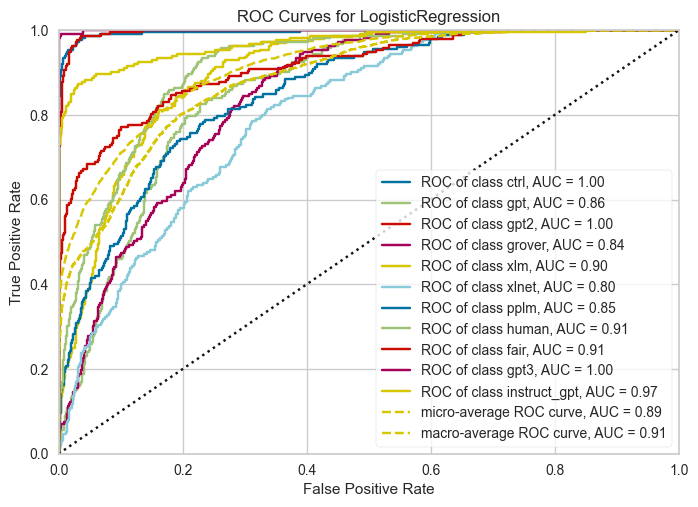

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       classes=['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm',
                'human', 'fair', 'gpt3', 'instruct_gpt'],
       estimator=LogisticRegression(C=0.01))

In [26]:
plot_ROC_curve(logistic_model)

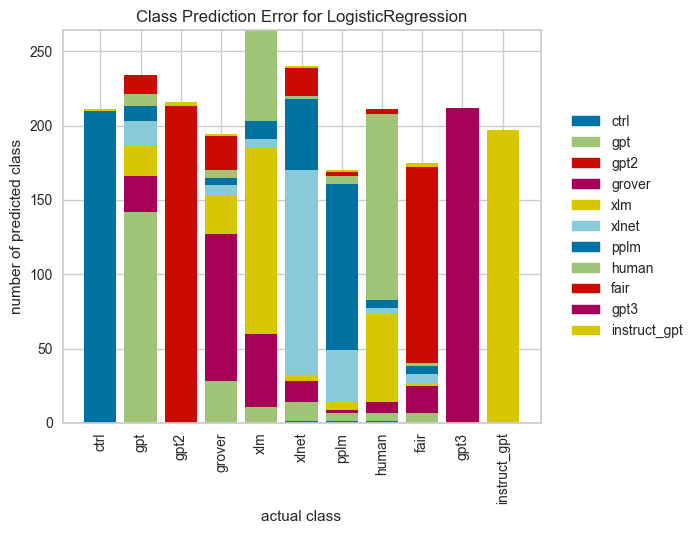

In [31]:
visualizer(logistic_model)

In [32]:
get_confusion_matrix(logistic_model)

TypeError: get_confusion_matrix() missing 1 required positional argument: 'roc_results'

In [33]:
matrix = confusion_matrix(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'])
mat = matrix.diagonal()/matrix.sum(axis=1)
print(classification_report(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover','xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'],
                            digits=4))
print('confusion matrix: ', mat)

Accuracy = accuracy_score(y_test,pred)
F1 = f1_score(y_test, pred, average='macro')
print("Accuracy:", Accuracy)

rec = recall_score(y_test, pred, average='macro')
print('Recall: ', rec)
prec = precision_score(y_test, pred, average='macro')
print('Precision: ', prec)

print('F1:', F1)

              precision    recall  f1-score   support

        ctrl     0.9953    0.9859    0.9906       213
         gpt     0.9861    1.0000    0.9930       213
        gpt2     0.5103    0.4648    0.4865       213
      grover     0.5750    0.6449    0.6079       214
         xlm     1.0000    0.9907    0.9953       214
       xlnet     1.0000    0.9249    0.9610       213
        pplm     0.7543    0.6735    0.7116       196
       human     0.6588    0.5657    0.6087       198
        fair     0.6068    0.6667    0.6353       213
        gpt3     0.4464    0.5208    0.4808       240
instruct_gpt     0.5924    0.5869    0.5896       213

    accuracy                         0.7286      2340
   macro avg     0.7387    0.7295    0.7328      2340
weighted avg     0.7357    0.7286    0.7309      2340

confusion matrix:  [0.98591549 1.         0.46478873 0.64485981 0.99065421 0.92488263
 0.67346939 0.56565657 0.66666667 0.52083333 0.58685446]
Accuracy: 0.7286324786324786
Recall:  0.7295

### XG Boost

In [52]:
import xgboost

from sklearn.preprocessing import LabelEncoder

# encode class labels into integers
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

xgboost_model = xgboost.XGBClassifier()

parameters = { 'max_depth' : [10, 20, 30],
               'n_estimators' : [90, 150, 180],
               'min_child_weight' : [1, 5, 10 ]
 }

cross_validation = 3
scoring_metric = "f1"
xgboost_model_cv = GridSearchCV(xgboost_model, 
                                parameters,
                                cv = cross_validation,
                                scoring = scoring_metric,
                                return_train_score=True)

xgboost_model_cv.fit(X_train, y_train)
print('Best Params ', xgboost_model_cv.best_params_)

KeyboardInterrupt: 

In [53]:
parameters = { 'max_depth' : 30,
               'min_child_weight' : 1,
               'n_estimators' : 150
 }

xgboost_model = xgboost.XGBClassifier(max_depth = parameters['max_depth'],
                                      min_child_weight = parameters['min_child_weight'],
                                      n_estimators = parameters['n_estimators'])
xgboost_model.fit(X_train, y_train)
pred = xgboost_model.predict(X_test)

In [55]:
class_labels = encoder.classes_
class_to_int = dict(zip(class_labels, range(len(class_labels))))
print(class_to_int)

{'ctrl': 0, 'fair': 1, 'gpt': 2, 'gpt2': 3, 'gpt3': 4, 'grover': 5, 'human': 6, 'instruct_gpt': 7, 'pplm': 8, 'xlm': 9, 'xlnet': 10}


In [56]:
matrix = confusion_matrix(y_test, pred, labels = list(class_to_int.values()))
mat = matrix.diagonal()/matrix.sum(axis=1)
print(classification_report(y_test, pred, labels = list(class_to_int.values()),
                            digits=4))
print('confusion matrix: ', mat)

Accuracy = accuracy_score(y_test,pred)
F1 = f1_score(y_test, pred, average='macro')
print("Accuracy:", Accuracy)

rec = recall_score(y_test, pred, average='macro')
print('Recall: ', rec)
prec = precision_score(y_test, pred, average='macro')
print('Precision: ', prec)

print('F1:', F1)

              precision    recall  f1-score   support

           0     0.9722    0.9859    0.9790       213
           1     0.6723    0.7512    0.7095       213
           2     0.9906    0.9906    0.9906       213
           3     0.6853    0.6338    0.6585       213
           4     0.6603    0.7208    0.6892       240
           5     0.6910    0.7523    0.7204       214
           6     0.8528    0.7020    0.7701       198
           7     0.6560    0.6714    0.6636       213
           8     0.7921    0.7194    0.7540       196
           9     0.9905    0.9766    0.9835       214
          10     1.0000    0.9906    0.9953       213

    accuracy                         0.8090      2340
   macro avg     0.8148    0.8086    0.8103      2340
weighted avg     0.8130    0.8090    0.8096      2340

confusion matrix:  [0.98591549 0.75117371 0.99061033 0.63380282 0.72083333 0.75233645
 0.7020202  0.6713615  0.71938776 0.97663551 0.99061033]
Accuracy: 0.808974358974359
Recall:  0.80860

### SVM

In [35]:
svm_model = SVC()

parameters = { 'kernel' : ['poly', 'rbf', 'sigmoid'],
               'max_iter' : [20, 50, 100]
 }

cross_validation = 3
scoring_metric = "f1"
svm_model_cv = GridSearchCV(svm_model, 
                            parameters,
                            cv = cross_validation,
                            scoring = scoring_metric,
                            return_train_score=True)

svm_model_cv.fit(X_train, y_train)
print('Best Params ', svm_model_cv.best_params_)

Best Params  {'kernel': 'poly', 'max_iter': 20}


In [41]:
parameters = {
         'kernel' : 'poly',
         'max_iter' : 20,
        }

svm_model = SVC(kernel = parameters['kernel'],
max_iter = parameters['max_iter'], probability = True)

svm_model.fit(X_train, y_train)
pred = svm_model.predict(X_test)

In [42]:
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, accuracy_score, confusion_matrix
matrix = confusion_matrix(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'])
mat = matrix.diagonal()/matrix.sum(axis=1)
print(classification_report(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover','xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'],
                            digits=4))
print('confusion matrix: ', mat)

Accuracy = accuracy_score(y_test,pred)
F1 = f1_score(y_test, pred, average='macro')
print("Accuracy:", Accuracy)

rec = recall_score(y_test, pred, average='macro')
print('Recall: ', rec)
prec = precision_score(y_test, pred, average='macro')
print('Precision: ', prec)

print('F1:', F1)

              precision    recall  f1-score   support

        ctrl     0.9916    0.5540    0.7108       213
         gpt     0.9679    0.9906    0.9791       213
        gpt2     0.1765    0.0141    0.0261       213
      grover     0.2457    0.2009    0.2211       214
         xlm     0.9769    0.9860    0.9814       214
       xlnet     0.1813    0.9812    0.3060       213
        pplm     0.8148    0.2245    0.3520       196
       human     0.6316    0.0606    0.1106       198
        fair     0.2143    0.0986    0.1350       213
        gpt3     0.1962    0.2125    0.2040       240
instruct_gpt     1.0000    0.0516    0.0982       213

    accuracy                         0.3991      2340
   macro avg     0.5815    0.3977    0.3749      2340
weighted avg     0.5751    0.3991    0.3750      2340

confusion matrix:  [0.55399061 0.99061033 0.01408451 0.20093458 0.98598131 0.98122066
 0.2244898  0.06060606 0.09859155 0.2125     0.05164319]
Accuracy: 0.39914529914529917
Recall:  0.397

### Binomial Naive Bayes 

In [50]:
bnb_model = BernoulliNB()
bnb_model.fit(X_train, y_train)
pred = bnb_model.predict(X_test)

In [51]:
matrix = confusion_matrix(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover', 'xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'])
mat = matrix.diagonal()/matrix.sum(axis=1)
print(classification_report(y_test, pred, labels = ['ctrl', 'gpt', 'gpt2', 'grover','xlm', 'xlnet', 'pplm', 'human', 'fair', 'gpt3', 'instruct_gpt'],
                            digits=4))
print('confusion matrix: ', mat)

Accuracy = accuracy_score(y_test,pred)
F1 = f1_score(y_test, pred, average='macro')
print("Accuracy:", Accuracy)

rec = recall_score(y_test, pred, average='macro')
print('Recall: ', rec)
prec = precision_score(y_test, pred, average='macro')
print('Precision: ', prec)

print('F1:', F1)

              precision    recall  f1-score   support

        ctrl     0.9752    0.9249    0.9494       213
         gpt     0.9381    0.9953    0.9658       213
        gpt2     0.4225    0.4225    0.4225       213
      grover     0.8165    0.6028    0.6935       214
         xlm     1.0000    0.9112    0.9535       214
       xlnet     0.9752    0.9249    0.9494       213
        pplm     0.5567    0.5765    0.5664       196
       human     0.8839    0.5000    0.6387       198
        fair     0.6913    0.7465    0.7178       213
        gpt3     0.4392    0.8875    0.5876       240
instruct_gpt     0.7018    0.3756    0.4893       213

    accuracy                         0.7197      2340
   macro avg     0.7637    0.7152    0.7213      2340
weighted avg     0.7608    0.7197    0.7215      2340

confusion matrix:  [0.92488263 0.99530516 0.42253521 0.60280374 0.91121495 0.92488263
 0.57653061 0.5        0.74647887 0.8875     0.37558685]
Accuracy: 0.7196581196581197
Recall:  0.7152

In [59]:
import tabulate
print('Task P2 : TF vectors - Model all-mpnet-base-v2')
conclusion = [['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'],
              ['Logistic Regression', 72.8, 73.8, 72.9, 73.3],
              ['XGBoost Classifier', 80.8, 81.4, 80.8, 81.0],
              ['Random Forest Classifier', 60.1, 71.7, 60.1, 57.3],
              ['SVM Classifier', 40.1, 58.1, 40.7, 37.5],
              ['Naive Bayes Classifier',  72.1, 76.3, 72.1, 72.1],   
             ]
print(tabulate.tabulate(conclusion, tablefmt='fancy_grid'))

Task P2 : TF vectors - Model all-mpnet-base-v2
╒══════════════════════════╤══════════╤═══════════╤════════╤══════════╕
│ Model                    │ Accuracy │ Precision │ Recall │ F1 Score │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┤
│ Logistic Regression      │ 72.8     │ 73.8      │ 72.9   │ 73.3     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┤
│ XGBoost Classifier       │ 80.8     │ 81.4      │ 80.8   │ 81.0     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┤
│ Random Forest Classifier │ 60.1     │ 71.7      │ 60.1   │ 57.3     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┤
│ SVM Classifier           │ 40.1     │ 58.1      │ 40.7   │ 37.5     │
├──────────────────────────┼──────────┼───────────┼────────┼──────────┤
│ Naive Bayes Classifier   │ 72.1     │ 76.3      │ 72.1   │ 72.1     │
╘══════════════════════════╧══════════╧═══════════╧════════╧══════════╛
